In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils as u

EQ_CENTS = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
JI_CENTS = np.array([0, 90, 112, 182, 204, 294, 316, 386, 408, 498, 520, 590, 612, 702, 792, 814, 884, 906, 996, 1018, 1088, 1110, 1200])

# %matplotlib widget

In [3]:
# Load audiofile at 16kHz
audiofile = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin_edited.mp3"
sr = 16000
y, sr = u.load_normalize(audiofile, sr = sr)

# Apply a high pass filter to the audio signal (160 Hz)
y_filt = u.high_pass(y, sr, 160, order = 10)
y_filt = y_filt.astype(np.float32)  

In [4]:
# Identify the tonic
tonic = u.identify_tonic(y, sr, binResolution = 1)
print(f"Identified tonic: {tonic} Hz")

Identified tonic: 181.02346801757812 Hz


In [5]:
# Calculate raw pitch with melodia
hopsize_ms = 7.5
binResolution = 1
hopSize = u.ms_to_samples(hopsize_ms, sr)
minFrequency = tonic - 1
f0, conf = u.melodia(y, sr, hopSize = hopSize, minFrequency = minFrequency, binResolution = binResolution)

In [6]:
# Length of audio in seconds
length = len(y)/sr
# Pitch contour frame rate
frameRate = int(len(f0)/length)  

print("Pitch contour frame rate: ", frameRate)

Pitch contour frame rate:  133


In [55]:
# Save the pitch contour
pitchfile = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin_edited_pitch.txt"
times = np.linspace(0, length, len(f0))
np.savetxt(pitchfile, np.array([times, f0]).T)


In [56]:
# Load the pitch contour
times, f0 = np.loadtxt(pitchfile).T

In [57]:
# Get voiced segments
voiced_segments = u.voiced_segments(f0)
print(len(voiced_segments))

826


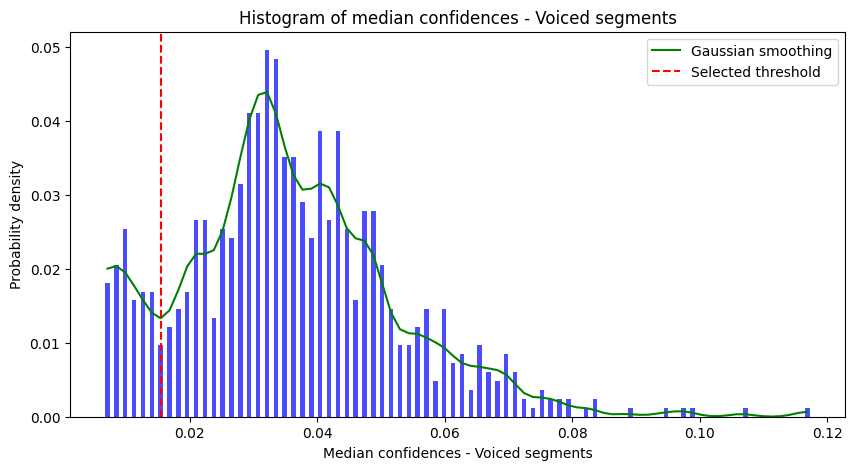

In [58]:
# Removing segments with low confidence estimation
median_conf = u.median_confidences(conf, voiced_segments)
plt.figure(figsize=(10, 5))
hist, bin_edges = np.histogram(median_conf, bins = 80, density = True)
hist = hist/np.sum(hist)
peaks = u.find_minimas(hist, height = 0.01)
gaussian_fit = u.gaussian_filter(hist, 10, sigma = 1.5)
plt.bar(bin_edges[:-1], hist, width = 0.5*(bin_edges[1] - bin_edges[0]), color = 'b', alpha = 0.7)
plt.plot(bin_edges[:-1], gaussian_fit, color = 'g', label = "Gaussian smoothing")
plt.axvline(x = bin_edges[peaks[0]], color = 'r', linestyle = '--', label = "Selected threshold")
plt.xlabel("Median confidences - Voiced segments")
plt.ylabel("Probability density")
plt.title("Histogram of median confidences - Voiced segments")
plt.legend()
plt.show()


In [ ]:
# Correcting octave errors

In [ ]:
# Pitch contour smoothing and interpolation

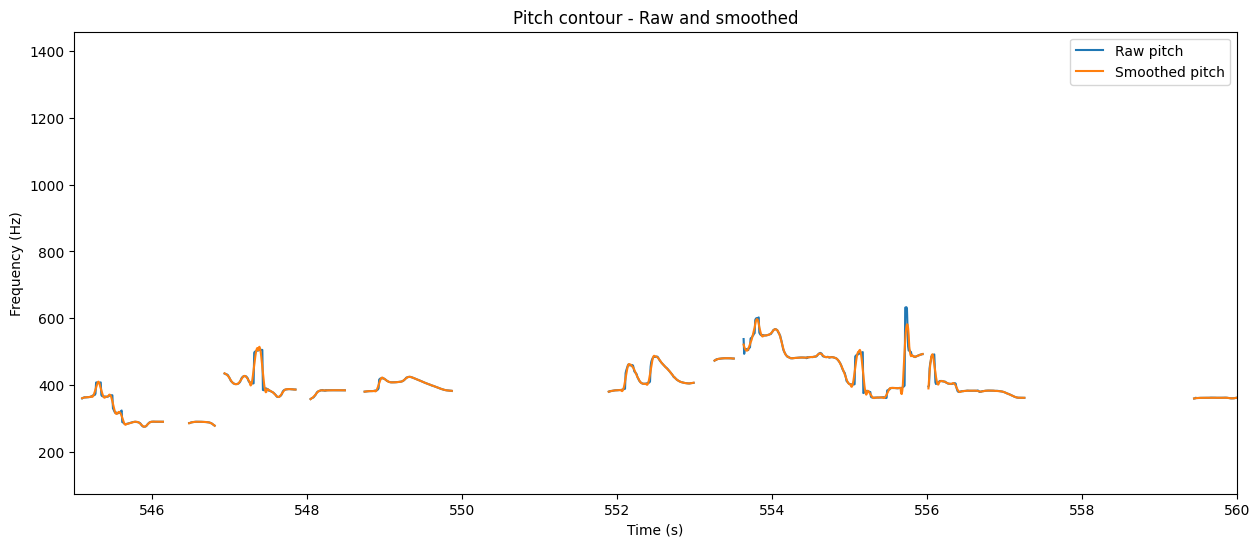

In [9]:
cents = u.hz_to_cents(f0, tonic)
window_ms = 101
window_size = u.ms_to_samples(window_ms, 133) + 2
savgol = u.savitsky_golay_filter(f0, window_size=window_size, order=2)
times = np.linspace(0, len(y)/sr, len(f0))

plt.figure(figsize=(15, 6))
plt.plot(times, np.where(f0>0, f0, np.nan), label='Raw pitch')
plt.plot(times, np.where(f0>0, savgol, np.nan), label='Smoothed pitch')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.xlim([545, 560])
plt.title('Pitch contour - Raw and smoothed')
plt.show()

In [10]:
# Sonify pitch contour and save
times = np.linspace(0, len(y)/sr, len(f0))
y_pitch = u.sonify_pitch_contour(times, f0, sr = sr)
u.save_audio("thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin_pitch.wav", y_pitch, sr)

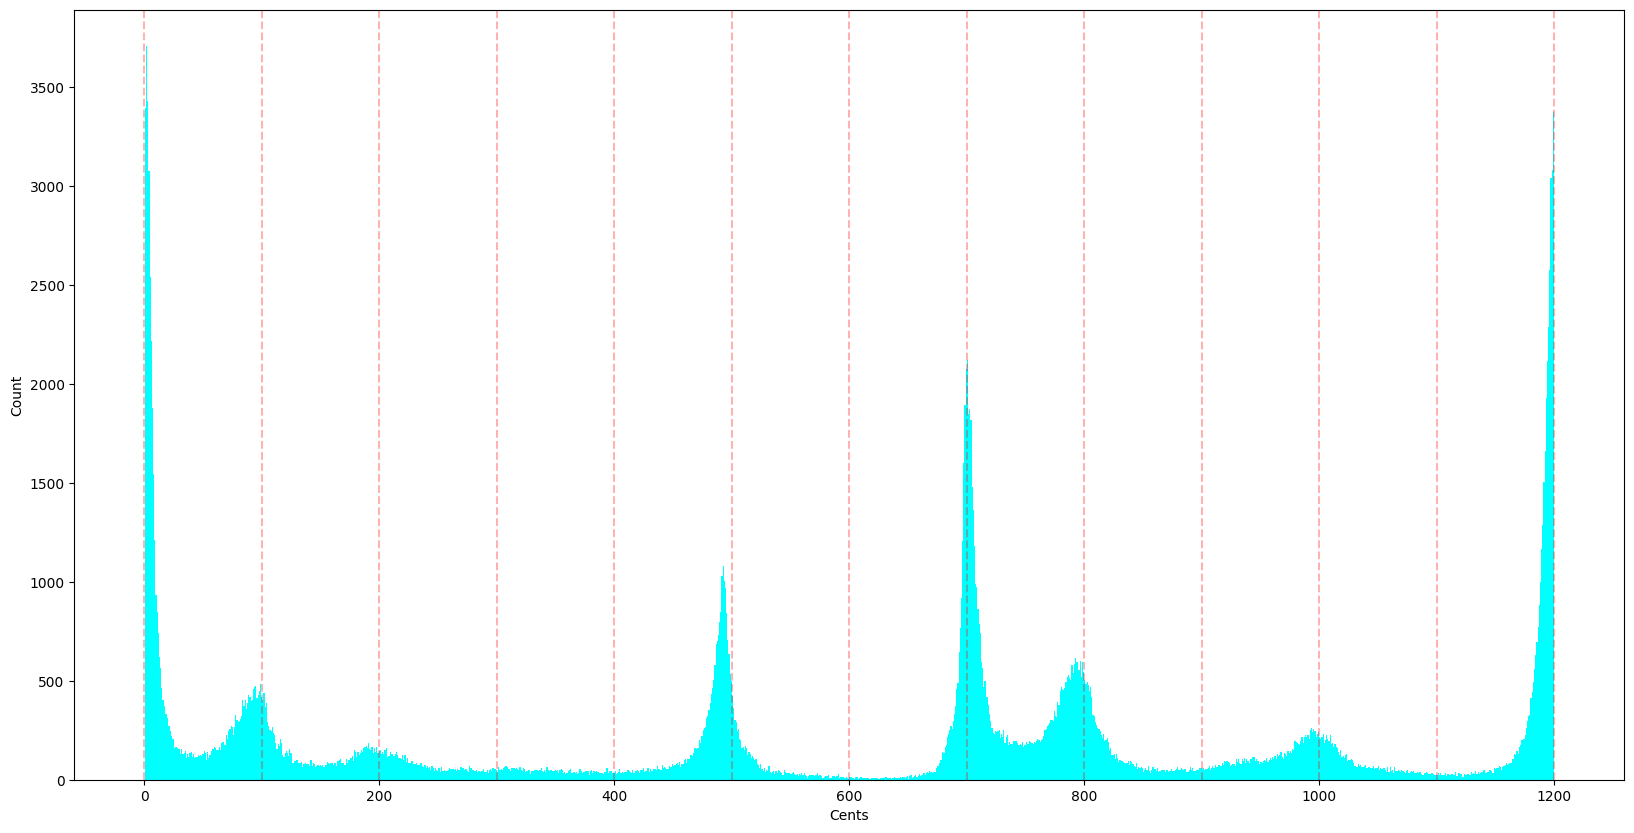

In [21]:
# Convert to cents and plot
cents_vi = u.hz_to_cents(f0, tonic)
# Wrap cents to one octave
cents_vi = u.wrap_to_octave(cents_vi)
u.interval_histogram(cents_vi, bins = 1200, tuning = "EQ")

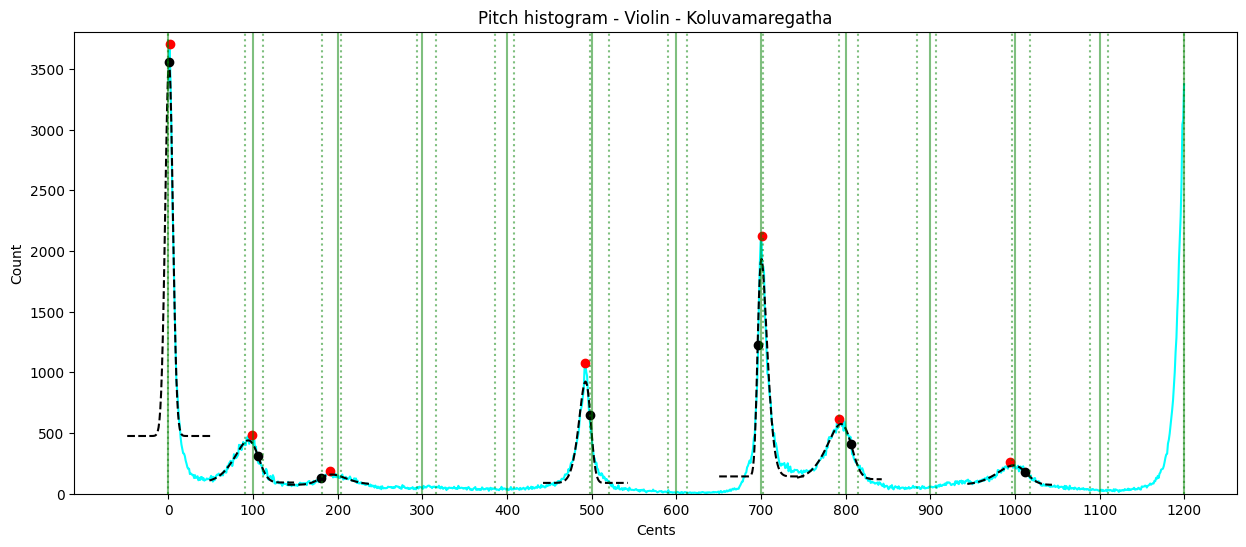

In [117]:
bins = np.linspace(0, 1200, 1201)
hist, bin_edges = np.histogram(cents_vi, bins = bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2    
peaks_vi, _ = u.find_peaks(hist, height = 120, distance = 50)
# Filter peaks such that only expected peaks are retained
for peak in peaks_vi:
    # Find closest peak in JI_CENTS, and difference from it
    closest_peak = np.argmin(np.abs(JI_CENTS - bin_centers[peak]))
    diff = np.abs(JI_CENTS[closest_peak] - bin_centers[peak])
    if diff > 20:
        peaks_vi = peaks_vi[peaks_vi != peak]

peak_dict = u.fit_histogram(peaks_vi, cents_vi)
        
plt.figure(figsize=(15, 6))
plt.plot(bin_centers, hist, color = "cyan")
plt.plot(bin_centers[peaks_vi], hist[peaks_vi], 'ro')

# Plot each fitted peak
for peak, params in peak_dict.items():
    x_fit = np.linspace(peak - 50, peak + 50, 101)
    best_fit = u.gaussian(x_fit, *params)
    plt.plot(x_fit, best_fit, 'k--')
    plt.plot(params[1], params[0] + params[3], 'ko')

for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.xticks(np.arange(0, 1201, 100))
plt.ylim(0, np.max(hist) + 100)
plt.ylabel("Count")
# plt.xlim([950, 1050])
plt.title("Pitch histogram - Violin - Koluvamaregatha")

plt.show()

In [89]:
for peak, params in peak_dict.items():
    print(peak, params)

1.5 [3.08201479e+03 7.74518346e-01 4.49259162e+00 4.75707195e+02
 1.87562574e-02]
98.5 [221.43868028 105.76641296 -22.35154353  92.36384357   2.43247061]
190.5 [ 55.31884695 180.15320799  24.25986119  74.27871692   2.1519128 ]
492.5 [559.37079064 498.24890738  10.56982304  89.21686482  -2.03402774]
700.5 [1086.9902758   695.96107604    9.44478584  142.52975937    3.00346908]
792.5 [291.71928541 806.07766601  22.9997134  119.30589849  -2.3907495 ]
993.5 [ 105.0699231  1011.98355685   26.65179745   73.22332296   -2.17931685]


In [98]:
# Load the pitch file for the vocals, and tonic file
pitch_file = "thodi/Koluvamaregatha/Koluvamaregatha.pitch.txt"
tonic_file = "thodi/Koluvamaregatha/Koluvamaregatha.ctonic.txt"
# Parse the pitch file, first column is time, second column is pitch
times, f0_vocals, _ = u.parse_pitch_file(pitch_file)
tonic_vocals = np.loadtxt(tonic_file)

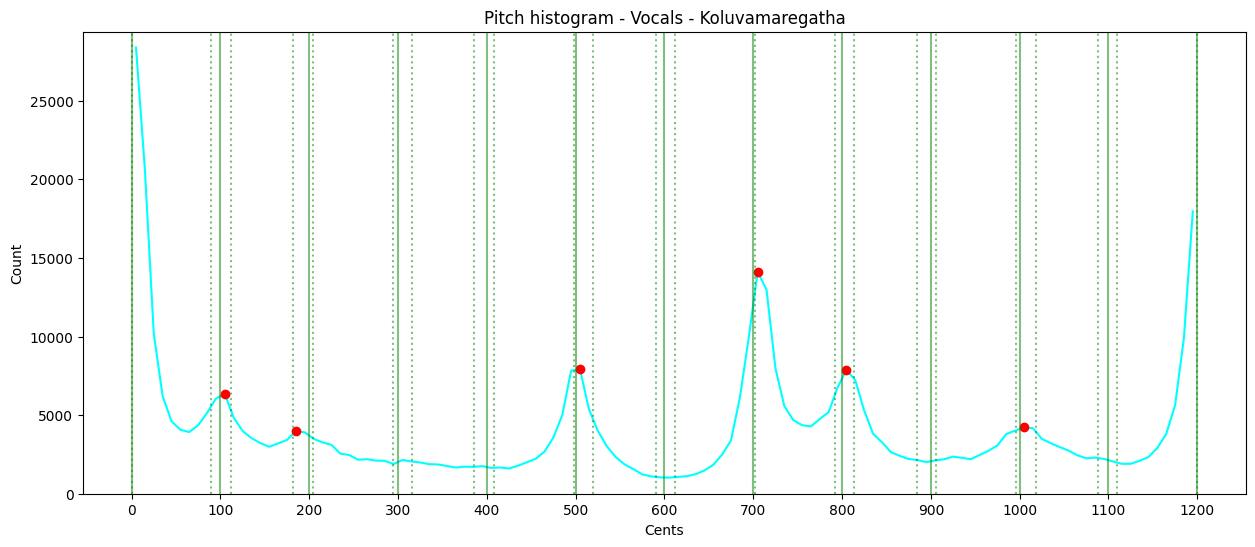

In [147]:
# Convert to cents and plot
cents_vo = u.hz_to_cents(f0_vocals, tonic_vocals)
# Wrap cents to one octave
cents_vo = u.wrap_to_octave(cents_vo)

bins = np.linspace(0, 1200, 121)
hist, bin_edges = np.histogram(cents_vo, bins = bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2 

# Find peaks in the histogram
peaks_vo, _ = u.find_peaks(hist, height = 3000)

# Filter peaks such that only expected peaks are retained
for peak in peaks_vo:
    # Find closest peak in JI_CENTS, and difference from it
    closest_peak = np.argmin(np.abs(JI_CENTS - bin_centers[peak]))
    diff = np.abs(JI_CENTS[closest_peak] - bin_centers[peak])
    if diff > 20:
        peaks_vo = peaks_vo[peaks_vo != peak]

# Fit the peaks
# peak_dict = u.fit_histogram(peaks_vo, cents_vo)

# # Plot each fitted peak
# for peak, params in peak_dict.items():
#     x_fit = np.linspace(peak - 50, peak + 50, 101)
#     best_fit = u.gaussian(x_fit, *params)
#     plt.plot(x_fit, best_fit, 'k--')
#     plt.plot(params[1], params[0] + params[3], 'ko')

plt.figure(figsize=(15, 6))   

plt.plot(bin_centers, hist, color = "cyan")
plt.plot(bin_centers[peaks_vo], hist[peaks_vo], 'ro')
for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.xticks(np.arange(0, 1201, 100))
plt.ylim(0, np.max(hist) + 1000)
plt.ylabel("Count")
plt.title("Pitch histogram - Vocals - Koluvamaregatha")

plt.show()

In [39]:
import pandas as pd
notes = ['S', 'R1', 'G2', 'M1', 'P', 'D1', 'N2']
print(peaks_vi)
print(peaks_vo)

[   1   98  190  492  700  792  993 1168]
[  10  100  180  500  700  750  800 1000 1190]


In [40]:
# For each element in peaks_vi, find the closest element in JI_CENTS and EQ_CENTS
# For each element in peaks_vo, find the closest element in JI_CENTS and EQ_CENTS

# Violin
violin_peaks = []
for peak in peaks_vi:
    closest_JI = np.argmin(np.abs(JI_CENTS - bin_centers[peak]))
    closest_EQ = np.argmin(np.abs(EQ_CENTS - bin_centers[peak]))
    violin_peaks.append((bin_centers[peak], JI_CENTS[closest_JI], EQ_CENTS[closest_EQ]))

# Vocals
vocals_peaks = []
for peak in peaks_vo:
    closest_JI = np.argmin(np.abs(JI_CENTS - bin_centers[peak]))
    closest_EQ = np.argmin(np.abs(EQ_CENTS - bin_centers[peak]))
    vocals_peaks.append((bin_centers[peak], JI_CENTS[closest_JI], EQ_CENTS[closest_EQ]))

print(violin_peaks)
print(vocals_peaks)

[(1.5, 0, 0), (98.5, 90, 100), (190.5, 182, 200), (492.5, 498, 500), (700.5, 702, 700), (792.5, 792, 800), (993.5, 996, 1000), (1168.5, 1200, 1200)]
[(10.5, 0, 0), (100.5, 90, 100), (180.5, 182, 200), (500.5, 498, 500), (700.5, 702, 700), (750.5, 792, 800), (800.5, 792, 800), (1000.5, 996, 1000), (1190.5, 1200, 1200)]
